# Twitter Sentiment Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Twitter Sentiments.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [47]:
df['clean_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [8]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit can't cause they don't off...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model love take with time urð±!!! ððð...
4,5,0,factsguide: society now #motivation,factsguide: society #motivation


In [9]:
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())

In [10]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, can't, caus, they, don'...
2                              [bihday, your, majesti]
3    [#model, love, take, with, time, urð±!!!, ð...
4                       [factsguide:, societi, #motiv]
Name: clean_tweet, dtype: object

In [11]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
    
df['clean_tweet'] = tokenized_tweet
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit can't caus they don't offer...
2,3,0,bihday your majesty,bihday your majesti
3,4,0,#model i love u take with u all the time in ...,#model love take with time urð±!!! ððð...
4,5,0,factsguide: society now #motivation,factsguide: societi #motiv


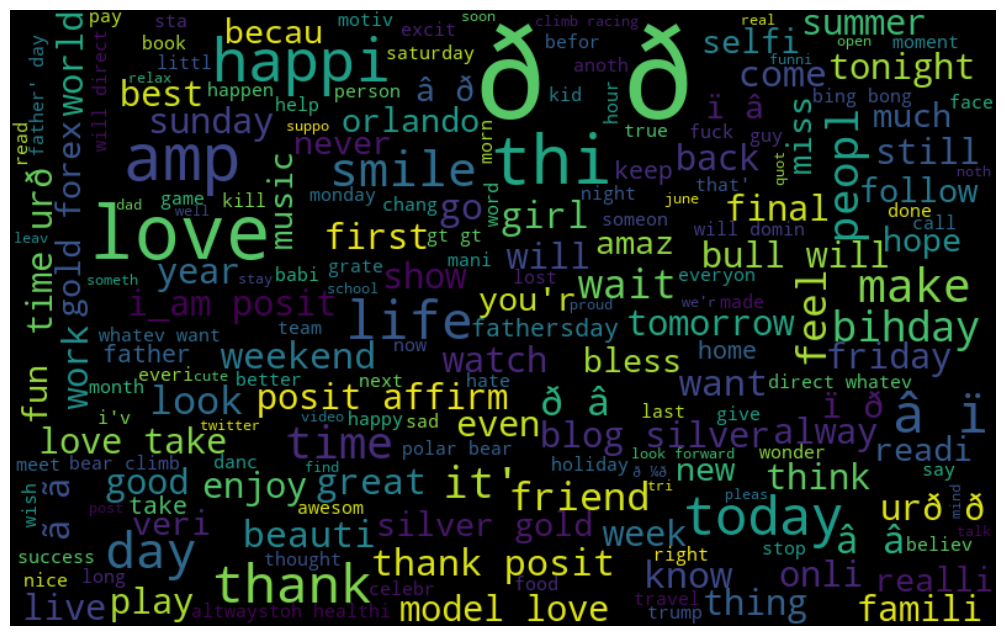

In [19]:
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

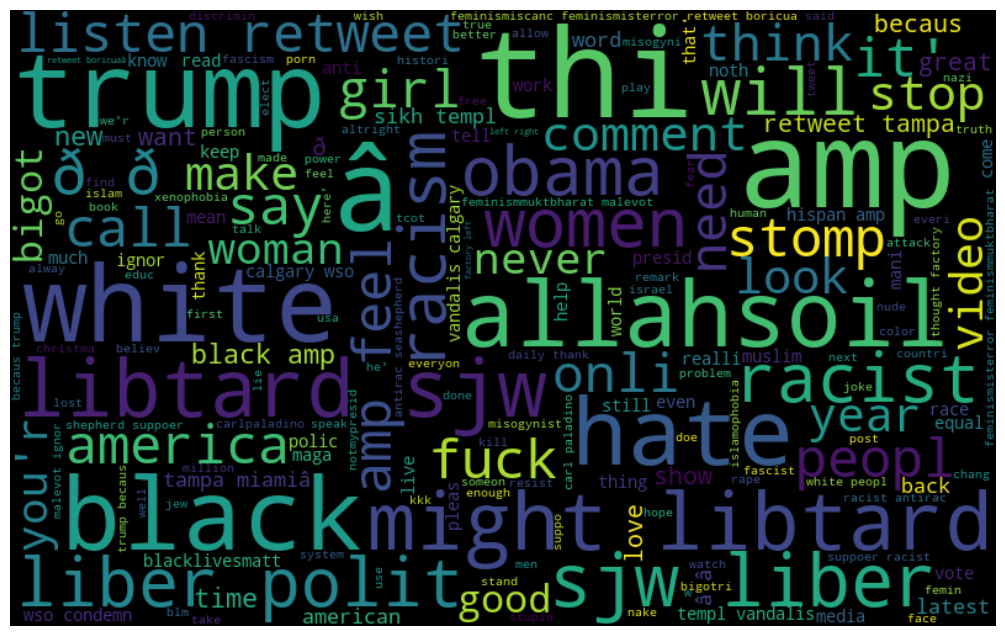

In [20]:
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
def hashtag_extract(tweets):
    hashtags = []
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags    

In [23]:
ht_positive = hashtag_extract(df['clean_tweet'][df['label']==0])

ht_negative = hashtag_extract(df['clean_tweet'][df['label']==1])

In [25]:
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])

In [26]:
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,run,70
1,lyft,2
2,disapoint,1
3,getthank,2
4,model,374


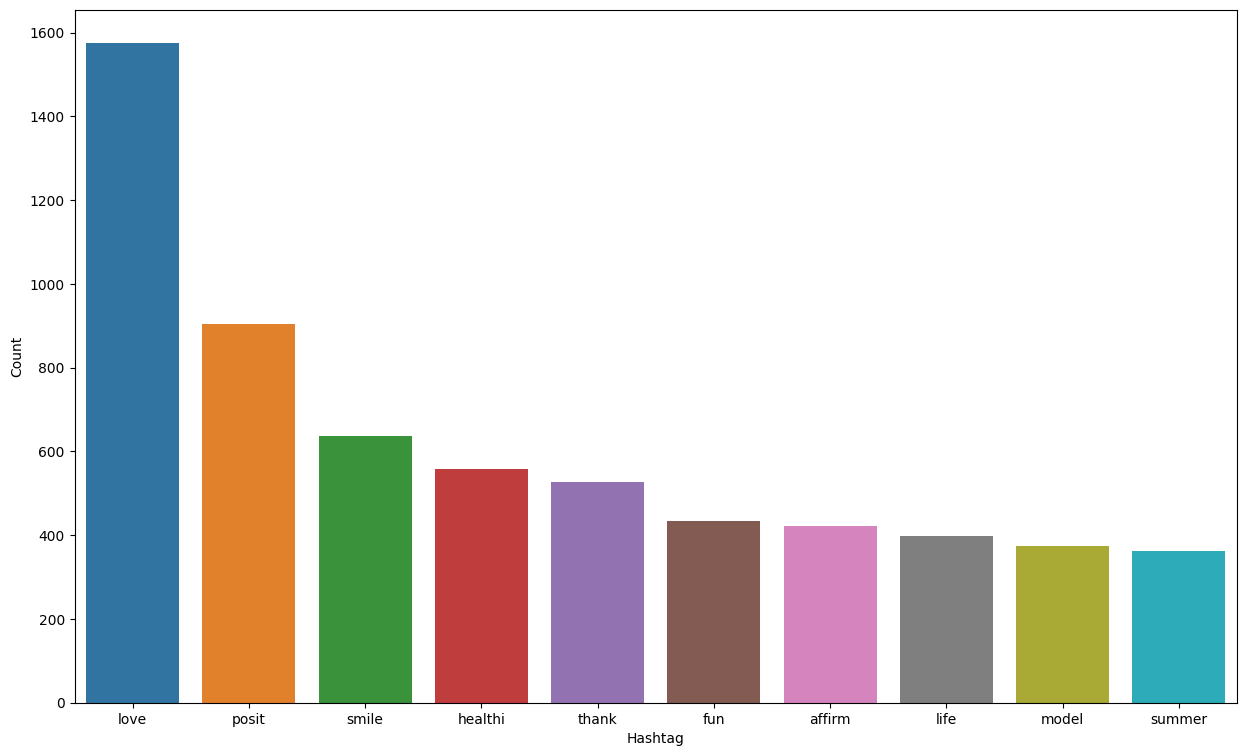

In [27]:
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [28]:
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,cnn,9
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,2


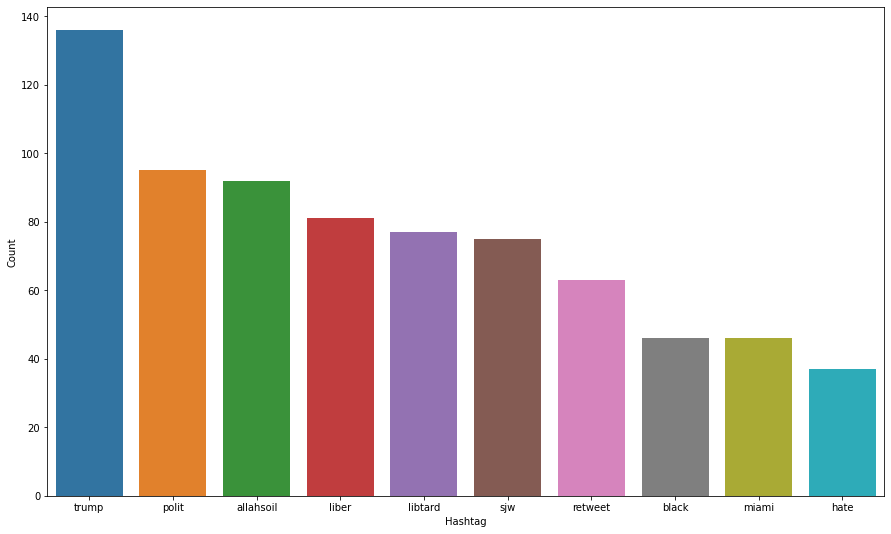

In [27]:
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['clean_tweet'])

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, df['label'], random_state=42, test_size=0.25)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [43]:
model = LogisticRegression()
model.fit(x_train, y_train)

pred = model.predict(x_test)
f1_score(y_test, pred)

0.5083135391923991

In [44]:
accuracy_score(y_test,pred)

0.9481917156801402

In [45]:
pred_prob = model.predict_proba(x_test)

pred = pred_prob[:, 1] >= 0.3

pred = pred.astype(int) 
f1_score(y_test, pred)

0.560856864654333

In [44]:
accuracy_score(y_test,pred)

0.9433112251282693